In [21]:
#___第一步 掛硬碟
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#第二步 載入第三方函示庫
# --- 參數設定 ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# Update these paths to your dataset location on Google Drive
train_dir = '/content/drive/MyDrive/1027/data-20251027T075125Z-1-001/data'
val_dir = '/content/drive/MyDrive/1027/data-20251027T075125Z-1-001/data'

# --- 資料前處理 ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Changed to categorical for 3 classes
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Changed to categorical for 3 classes
)

#第三步  資料增強與載入
# --- 載入預訓練的 VGG16 ---
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 凍結預訓練權重

# --- 建立分類頭 ---
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Changed to 3 classes
])

# --- 編譯模型 ---
model.compile(
    loss='categorical_crossentropy',  # Changed to categorical_crossentropy
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
#第四步 建立 VGG16 模型（遷移學習）
# --- 訓練 ---
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

# --- 解凍部分 VGG16 層進行微調（可選） ---
base_model.trainable = True
for layer in base_model.layers[:-4]:  # 只訓練最後4層
    layer.trainable = False

model.compile(
    loss='categorical_crossentropy',  # Changed to categorical_crossentropy
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)
#第五步  訓練模型與儲存
# --- 儲存模型 ---
model.save('cat_dog_rabbit_vgg16.h5')

Found 122 images belonging to 3 classes.
Found 122 images belonging to 3 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 155s 44s/step - accuracy: 0.4274 - loss: 1.1343 - val_accuracy: 0.5164 - val_loss: 0.8355
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 134s 39s/step - accuracy: 0.4173 - loss: 1.2495 - val_accuracy: 0.5246 - val_loss: 0.9298
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 133s 38s/step - accuracy: 0.5204 - loss: 0.9641 - val_accuracy: 0.6066 - val_loss: 0.7980
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 142s 38s/step - accuracy: 0.4869 - loss: 1.0108 - val_accuracy: 0.6393 - val_loss: 0.7627
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 133s 39s/step - accuracy: 0.6421 - loss: 0.7661 - val_accuracy: 0.5656 - val_loss: 0.7796
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 132s 38s/step - accuracy: 0.5907 - loss: 0.7791 - val_accuracy: 0.5984 - val_loss: 0.7458
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 132s 39s/step - accuracy: 0.4733 - loss: 0.8746 - val_accuracy: 0.6557 - val_loss: 0.6923
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 133s 38s/step - accuracy: 0.5837 - loss: 0.7333 - val_accuracy: 0.5984 - val_loss:

✅ 模型已載入成功！
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
dog.jpg → dogs (1.00)


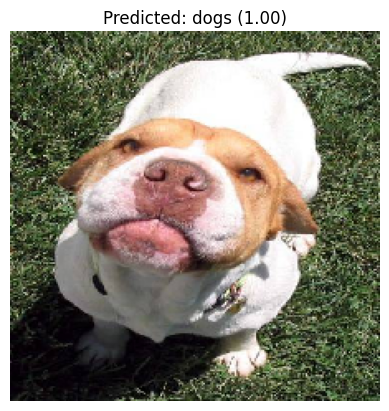

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
cat.jpg → dogs (1.00)


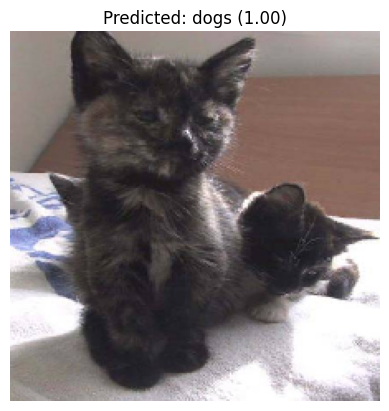

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import os
import matplotlib.pyplot as plt

# ============================
# 1️⃣ 載入模型
# ============================
model_path = '/content/cat_dog_rabbit_vgg16.h5'  # ← 修改成你的實際路徑
model = tf.keras.models.load_model(model_path)

# 確認模型載入成功
print("✅ 模型已載入成功！")

# ============================
# 2️⃣ 定義類別名稱
# ============================
# 根據訓練資料夾順序決定（train_generator.class_indices）
# 例如：{'cats': 0, 'dogs': 1, 'rabbits': 2}
class_names = ['cats', 'dogs', 'rabbits']  # ← 依你訓練的實際類別修改

# ============================
# 3️⃣ 預測資料夾路徑
# ============================
test_dir = '/content/drive/MyDrive/1027/data-20251027T075125Z-1-001/data/test'  # ← 你的測試資料夾

# ============================
# 4️⃣ 定義預測函式
# ============================
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # 使用與訓練相同的預處理

    preds = model.predict(img_array)
    pred_idx = np.argmax(preds, axis=1)[0]
    confidence = np.max(preds)
    label = class_names[pred_idx]
    return label, confidence

# ============================
# 5️⃣ 對資料夾中所有圖片做預測
# ============================
for img_file in os.listdir(test_dir):
    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(test_dir, img_file)
        label, confidence = predict_image(img_path)
        print(f"{img_file} → {label} ({confidence:.2f})")

        # 顯示圖片與預測結果
        img_show = image.load_img(img_path, target_size=(224, 224))
        plt.imshow(img_show)
        plt.title(f"Predicted: {label} ({confidence:.2f})")
        plt.axis('off')
        plt.show()
